In [1]:
import shap
import xgboost
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/ehambardzumy/Documents/big_data/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_num_items(item):
    if not pd.isna(item):
        return len(item.split(","))
    else:
        item
        
def get_year(item):
    if not pd.isna(item):
        return int(str(item).split("-")[0])
    else:
        item

In [3]:
df_raw = pd.read_csv("./train.csv")

In [4]:
# REMOVE 
# 'property_bedrooms', 
# 'property_max_guests'
# 'property_bathrooms'
# 'booking_price_covers'

features = [
                    'property_beds', 
                    'booking_availability_30',
                    'booking_availability_90',
                    'booking_availability_365',
                    'reviews_num',
                    'reviews_rating',
                    'reviews_acc',
                    'reviews_checkin',
                    'reviews_communication',
                    'reviews_location', 
                    'reviews_value', 

                    'property_id',
                    'property_type', 
                    'property_room_type', 
                    'property_bed_type',
                    'num_amenities',
                    'host_since',
                    'host_response_time',
                    'host_response_rate',
                    'n_verified_channels',
                    'booking_min_nights',
                    'booking_max_nights',
                    'booking_availability_60',
                    'booking_cancel_policy',
                    'reviews_cleanliness', 
                    'reviews_per_month',
                    'target']

In [5]:
df_raw['num_amenities'] = df_raw['property_amenities'].apply(get_num_items)
df_raw['n_verified_channels'] = df_raw['host_verified'].apply(get_num_items)
df_raw['host_since'] = df_raw['host_since'].apply(get_year)

# Temprarily drop NAs
df = df_raw[features].dropna()

df.set_index("property_id", 
             drop=True, 
             inplace=True)

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_columns = df.select_dtypes(include=numerics).columns 
non_numeric_cols = [col for col in df.columns if col not in numeric_columns]

In [7]:
X_train, X_validation = train_test_split(df, test_size=0.33, random_state=1982)

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train[numeric_columns])
X_scaled = scaler.transform(X_train[numeric_columns])

In [9]:
# random_state = 1981
# imp = IterativeImputer(max_iter=10, random_state=random_state, sample_posterior=True)
# imp.fit(X_scaled)
# X_scaled_imputed = imp.transform(X_scaled)

In [10]:
# X_scaled_imputed
scaled_df = pd.DataFrame(X_scaled)
scaled_df.columns = numeric_columns
scaled_df["property_id"] = list(X_train.index)

In [11]:
corrr = scaled_df.corr()
corrr.style.background_gradient(cmap='coolwarm')

,property_beds,booking_availability_30,booking_availability_90,booking_availability_365,reviews_num,reviews_rating,reviews_acc,reviews_checkin,reviews_communication,reviews_location,reviews_value,num_amenities,host_since,host_response_rate,n_verified_channels,booking_min_nights,booking_max_nights,booking_availability_60,reviews_cleanliness,reviews_per_month,target,property_id
property_beds,1.000000,0.038833,0.031203,0.086622,0.050012,-0.039452,-0.077297,-0.043733,-0.035203,-0.032385,-0.059397,0.148632,-0.051075,0.000830,0.002030,-0.025067,0.040125,0.041206,-0.036104,-0.031626,-0.009507,0.032910
booking_availability_30,0.038833,1.000000,0.837996,0.439532,-0.085165,-0.100640,-0.105114,-0.068364,-0.094527,-0.084828,-0.107950,-0.010996,0.023230,-0.110003,-0.037640,-0.049370,0.015132,0.922428,-0.033866,-0.098405,-0.025896,0.009628
booking_availability_90,0.031203,0.837996,1.000000,0.540510,-0.033931,-0.095850,-0.098321,-0.072417,-0.095651,-0.075449,-0.108172,0.008397,0.007101,-0.104204,-0.029161,-0.055163,0.010354,0.954459,-0.021288,-0.062392,-0.016270,0.012017
booking_availability_365,0.086622,0.439532,0.540510,1.000000,0.092476,-0.096614,-0.085837,-0.068383,-0.097374,-0.073795,-0.116355,0.047241,-0.128159,-0.040300,-0.066777,0.008716,0.024463,0.501663,-0.004509,-0.087922,-0.022210,0.037096
reviews_num,0.050012,-0.085165,-0.033931,0.092476,1.000000,0.021716,0.051635,0.033514,0.047630,0.009723,0.040155,0.052308,-0.163349,0.110602,-0.000326,-0.045714,0.006271,-0.048318,0.076724,0.589793,-0.004444,0.049559
reviews_rating,-0.039452,-0.100640,-0.095850,-0.096614,0.021716,1.000000,0.709374,0.578777,0.623414,0.493669,0.760146,0.154798,0.035251,0.066958,0.062665,-0.013155,-0.030350,-0.101396,0.663272,0.091488,0.015367,0.005918
reviews_acc,-0.077297,-0.105114,-0.098321,-0.085837,0.051635,0.709374,1.000000,0.511122,0.551892,0.414780,0.666645,0.143509,0.035326,0.077649,0.042976,0.003760,-0.046011,-0.102768,0.585473,0.120791,0.023893,0.043773
reviews_checkin,-0.043733,-0.068364,-0.072417,-0.068383,0.033514,0.578777,0.511122,1.000000,0.686052,0.368050,0.524041,0.087748,0.025081,0.033396,-0.021798,-0.003071,-0.020742,-0.075950,0.433220,0.065696,0.014804,0.040251
reviews_communication,-0.035203,-0.094527,-0.095651,-0.097374,0.047630,0.623414,0.551892,0.686052,1.000000,0.395082,0.570785,0.092471,0.037671,0.051819,0.043834,0.007393,-0.021276,-0.099077,0.410738,0.081409,0.021966,0.028286
reviews_location,-0.032385,-0.084828,-0.075449,-0.073795,0.009723,0.493669,0.414780,0.368050,0.395082,1.000000,0.508399,0.114387,0.018830,0.032881,0.046230,-0.007274,-0.016593,-0.078226,0.352657,0.087187,0.032953,0.023331


In [12]:
non_numeric_encoded = pd.get_dummies(X_train[non_numeric_cols])


for col in non_numeric_encoded.columns:
    non_numeric_encoded[col] = pd.Categorical(non_numeric_encoded[col])

In [13]:
X_train_fit = pd.merge(scaled_df, non_numeric_encoded.reset_index(), on='property_id')

In [14]:
X = scaled_df.loc[:, scaled_df.columns != 'target'].drop(columns = "property_id")
y = scaled_df.target

In [15]:
availability_cols = ['booking_availability_30', 
           'booking_availability_60', 
           'booking_availability_90', 
           'booking_availability_365']
pca = PCA(n_components=1)
X['availability'] = pca.fit_transform(X[availability_cols])
fff = pca.fit(X[availability_cols])

X.drop(availability_cols, axis=1, inplace=True)



review_cols = ['reviews_rating',
                    'reviews_acc',
                    'reviews_cleanliness', 
                    'reviews_checkin',
                    'reviews_communication',
                    'reviews_location', 
                    'reviews_value']
pca = PCA(n_components=1)
X['reviews'] = pca.fit_transform(X[review_cols])
fff = pca.fit(X[review_cols])
X.drop(review_cols, axis=1, inplace=True)



review_cols2 = ['reviews_num',
                    'reviews_per_month']
pca = PCA(n_components=1)
X['reviews_num_pca'] = pca.fit_transform(X[review_cols2])
X.drop(review_cols2, axis=1, inplace=True)

In [16]:
corrr = X.corr()
corrr.style.background_gradient(cmap='coolwarm')

,property_beds,num_amenities,host_since,host_response_rate,n_verified_channels,booking_min_nights,booking_max_nights,availability,reviews,reviews_num_pca
property_beds,1.000000,0.148632,-0.051075,0.000830,0.002030,-0.025067,0.040125,0.051655,0.059637,0.010311
num_amenities,0.148632,1.000000,0.035774,0.138274,0.068011,0.002869,-0.005726,0.013736,-0.161137,0.076507
host_since,-0.051075,0.035774,1.000000,0.057158,-0.131487,-0.051912,-0.003881,-0.013146,-0.040741,0.008468
host_response_rate,0.000830,0.138274,0.057158,1.000000,0.022253,0.003894,0.003901,-0.101540,-0.081914,0.164127
n_verified_channels,0.002030,0.068011,-0.131487,0.022253,1.000000,0.018163,-0.004325,-0.041739,-0.045790,0.021503
booking_min_nights,-0.025067,0.002869,-0.051912,0.003894,0.018163,1.000000,-0.002823,-0.047735,0.005893,-0.079992
booking_max_nights,0.040125,-0.005726,-0.003881,0.003901,-0.004325,-0.002823,1.000000,0.016479,0.034527,-0.001864
availability,0.051655,0.013736,-0.013146,-0.101540,-0.041739,-0.047735,0.016479,1.000000,0.118687,-0.066438
reviews,0.059637,-0.161137,-0.040741,-0.081914,-0.045790,0.005893,0.034527,0.118687,1.000000,-0.100621
reviews_num_pca,0.010311,0.076507,0.008468,0.164127,0.021503,-0.079992,-0.001864,-0.066438,-0.100621,1.000000


In [17]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.036
Date:                Sat, 01 Apr 2023   Prob (F-statistic):              0.410
Time:                        19:19:40   Log-Likelihood:                -4068.6
No. Observations:                2871   AIC:                             8159.
Df Residuals:                    2860   BIC:                             8225.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.119e-15    

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


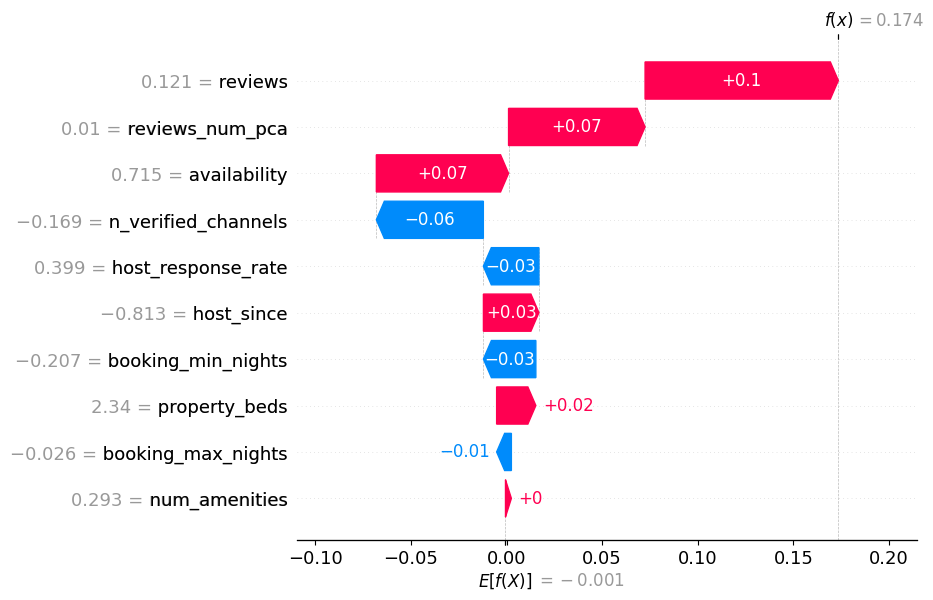

In [18]:
import xgboost
import shap

model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
